# Section 17: Python for Machine Learning: Logistic Regression 

### Logistic Regression Theory

In [103]:
## We want to learn about Logistic Regression as a method for Classification - The goal of classification is to 
## determine to which category a set of new observations belongs to.

## Some examples of classification problems: 
## 1 - Spam vs. 'Ham' problems 
## 2 - Loan Default (Yes/No)
## 3 - Disease Diagnosis -Has cancer or not? 

## All of the above examples are of Binary Classification - We have two classes. 

## ------------------------------------

## So far we've only seen Regression problems where we try to predict a continious value 
## Logitic Regression -> Allows us to solve classification problems -> We try to predict discrete categories. 
## Convention for binary classification -> We have two classes 0 and 1 

## ------------------------------------

## Linear Regression -> Bad fit when we have discrete categories -> Instead use a LR or Sigmoid hypotesis to 
## perform classification. 


## ------------------------------------

## Evaluating Classification models -> We can use a confusion matrix to evaluate/visualize classification models. 

### Logistic Regression with Python 

In [104]:
## We are going to be using the Titanic Dataset, we are going to tackle the following Classification problem: 

## Predict whether a passenger of the Titanic will survive or die (1/0) based on their features. 
## We are going to be using a semi-clean Titanic Dataset. 

## Kaggle -> Dataset hosting website -> We will obtain the data from here: Titanic: Machine Learning from Disaster 

In [105]:
## Imports 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

## Getting the Data
train = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Getting and Exploring the Data

In [106]:
train[train['Pclass']==1]['Age'].mean()

38.233440860215055

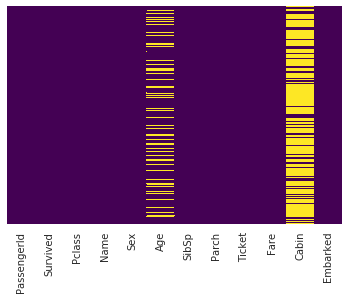

In [107]:
## Cleaning the Data 

## We are going to use seaborn to see where we are missing data: 

isnull= train.isnull() ##Use this boolean method to to transform our data into matrix form 
sns.heatmap(isnull, yticklabels = False, cbar = False, cmap = 'viridis')

In [108]:
### We can concude that we are mostly missing data from the Age and the Cabin columns. 
### Age data missing -> Around 20% -> Reasonable enough to use Imputation (Imputer) -> Using knowledge from other 
###                                   columns to fill in mising data.
### Cabin data -> Missing too much data to do something useful at a basic level. We can drop it later or change it to
###               another feature like cabin missing or something similar.

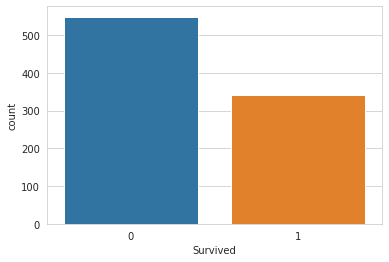

In [109]:
## More exploratory data analysis at a visual level.

sns.set_style('whitegrid')

##Always a good idea to see the ratio of the target label (survived / died)
sns.countplot(x = 'Survived', data = train)  

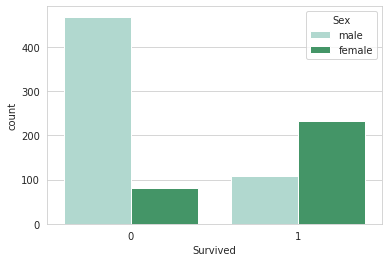

In [110]:
##Survival with a hue of sex 
sns.countplot(x = 'Survived', data = train, hue ='Sex', palette = 'BuGn')  

In [111]:
##Survival with a hue of passenger class
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

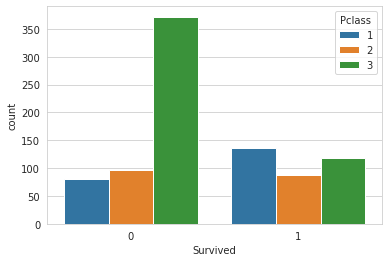

In [112]:
sns.countplot(x = 'Survived', data = train, hue = 'Pclass')

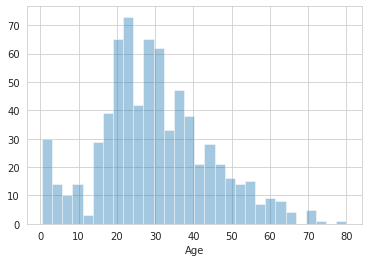

In [113]:
### Lets check out the distribution of ages 
sns.distplot(train['Age'].dropna(), kde = False, bins = 30) ##There is a small skew towards younger persons

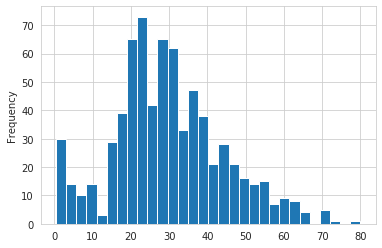

In [114]:
### We can do a similar plot with pandas directly 
train['Age'].plot(kind = 'hist', bins = 30)

In [115]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


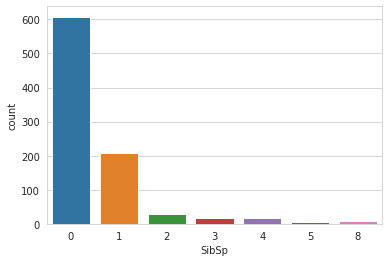

In [116]:
### Lets check out the distribution of passengers wiht siblings 
sns.countplot(x = 'SibSp', data = train) ##Most of the people didn't had a sibling/spouse onboard  

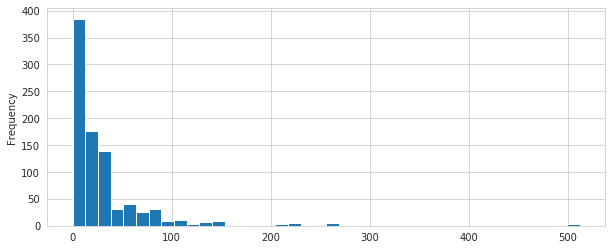

In [117]:
###Let's check the distribution of fares 
train['Fare'].plot(kind = 'hist', bins = 40, figsize = (10,4)) ## Most of the people paid 0 and 50 pounds/dollars
                                                               ## Fares are distributed towards cheaper tickets

In [118]:
### Lets try it out with cufflinks! 

import cufflinks as cf 
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected = True)
cf.go_offline()

In [119]:
train['Fare'].iplot(kind = 'hist', bins = 50)

### Cleaning the Data

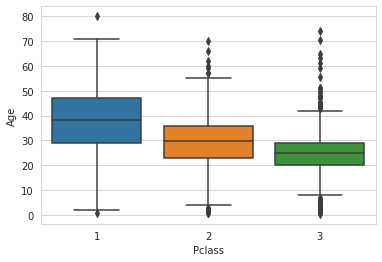

In [142]:
## Pt.2 Cleaning our Data -> Will allow us to transform our data to an acceptable form for our ML algorithms.

## We want to fill in missing data of the age column instead of just dropping the age column altogether 
## One way to do this is by filling in the missing values with the mean age of all the passengers 

## This is known as imputation -> We can also be more specific and impute the passenger age based on its class or
## some other feature -> Then the values we fill in will be representative of the sample of the population 
## they belong to -> e.g. Wealthy people tend to be older while younger people tend to be less wealthy

## Lets verify this with a seaborn boxplot:

sns.boxplot(x = 'Pclass', y = 'Age', data = train)

In [121]:
### Now, based on the above, we can use these average age values in order to impute the age based off the passenger
### class. 

## Lets create an imputer function:
def impute_age(data):
    
    age = data['Age']
    Pclass = data['Pclass']
    
    ##Compute the means
    class1, class2, class3 = (age[Pclass == i].mean() for i in range (1,4))
    
    imputed_age = []
    
    for j in range(len(data)): 
        if np.isnan(age.iloc[j]):
            if Pclass.iloc[j] == 1:
                imputed_age.append(class1)
            elif Pclass.iloc[j] == 2:
                imputed_age.append(class2)
            else:
                imputed_age.append(class3)
        else:
            imputed_age.append(age.iloc[j])
    
    return pd.DataFrame(imputed_age, index = data['Age'].index, columns = ['Age'])

In [122]:
### Lets call the Age imputer on the Age and Pclass columns
train['Age'] = impute_age(train)

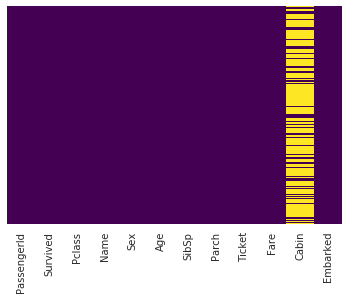

In [123]:
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [124]:
### The above function can be more easily implemented with the .apply method as follows: 

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 25
    else:
        return Age
    

In [125]:
train[['Age', 'Pclass']].apply(impute_age, axis = 1) 

0      22.00000
1      38.00000
2      26.00000
3      35.00000
4      35.00000
         ...   
886    27.00000
887    19.00000
888    25.14062
889    26.00000
890    32.00000
Length: 891, dtype: float64

In [126]:
### Dealing with the cabin column

##Too much missing data -> It is better to drop this column altogether
train.drop('Cabin', axis = 1, inplace = True) 

In [127]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


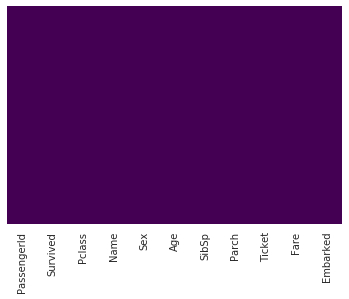

In [128]:
### Checkig the heatmap again: 
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [129]:
###Dealing with categorical features -> We need to convert categorical features into dummy variables using pandas
##                                      Otherwise, our ML algorithms will not be able to take in those features as
##                                      inputs 
##                                   -> We must encode these features in a way that an ML algorithm can understand.

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [130]:
###Let's first encode the Sex column in a dummy variable format: 

##To do so we use the pd.get_dummies() method -> Converts categorical values into indicator/dummy values
pd.get_dummies(train['Sex'])

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


In [131]:
### There is one issue with the above result -> The male column perfectly predicts the female column and viceversa.
### Then one column is a perfecr predictor of the other column -> Multiple colinearity issue 

##  To avoid this, we pass in the drop_first argument 
pd.get_dummies(train['Sex'], drop_first = True)


,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [132]:
### This is a better result and now we can create a new column in our Data Frame 
sex = pd.get_dummies(train['Sex'], drop_first = True)
                  
### We do a similar thing to the embark column 
embark = pd.get_dummies(train['Embarked'], drop_first = True)

In [133]:
embark

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
886,0,1
887,0,1
888,0,1
889,0,0


In [134]:
### Now we call the pd.concat method to add these Data Frames to train 

train = pd.concat([train, sex, embark], axis = 1)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


In [136]:
### Now that we have concatenated the indicator columns, we can drop the equivalent categorical columns 
### Also, we can drop other categorical columns such as ticket(Though some feature engineering could be performed)

train.drop(train['Sex', 'Embarked', 'Name', 'Ticket'], axis = 1, inplace = True)

In [137]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [138]:
### We can also drop the PaseengerId column since it is serves only as an index column 
train.tail()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
886,887,0,2,27.00000,0,0,13.00,1,0,1
887,888,1,1,19.00000,0,0,30.00,0,0,1
888,889,0,3,25.14062,1,2,23.45,0,0,1
889,890,1,1,26.00000,0,0,30.00,1,0,0
890,891,0,3,32.00000,0,0,7.75,1,1,0


In [140]:
train.drop('PassengerId', inplace = True, axis = 1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [141]:
### Exercise -> Do we also get the indicator variables of the Pclass column?

### C. Training and Evaluating our Logistic Regression Model

In [143]:
### In this section, we are going to treat our train data as if it were our whole data. Thus, we are going to
### obtain both the test and train sets from the Train Data Frame. 

## Regarding the titanic_test.csv file, we should clean the data as we did with the train data. However, 
## a pipeline should be used instead. We don't want to see the test set before training the model.

## Lets separate our data into features X and labels y:

## Data Science Work -> Strong in cleaning the data
X = train.drop('Survived', axis = 1)
y = train['Survived']

In [146]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [155]:
### Training the model 
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(solver = 'lbfgs', max_iter = 1000)

In [156]:
logmodel.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [157]:
## Making predictions 
predictions = logmodel.predict(X_test)

In [160]:
predictions[:5]

array([0, 1, 1, 0, 0])

In [161]:
y_test[:5]

331    0
700    1
748    0
751    1
481    0
Name: Survived, dtype: int64

In [162]:
##Evaluating our model 
from sklearn.metrics import classification_report ##Contains many types of scores (Precision, recall, F1 Score, etc)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       154
           1       0.77      0.68      0.73       114

    accuracy                           0.78       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268



In [163]:
### We can also call the confusion matrix 
from sklearn.metrics import confusion_matrix 

confusion_matrix(y_test, predictions)

array([[131,  23],
       [ 36,  78]])

In [ ]:
## Improving our model -> Use the whole train dataset as training set
            #          -> Feature engineering -> Extract more information from other features 
            #          -> Check out the Kaggle website for more info!